In [25]:
import matplotlib.pyplot as plt
import os
import pandas_datareader as pdr
import pandas as pd
import numpy as np

In [145]:
#Print version of pandas_datareader to cite in post
print(pdr.__version__)

0.7.0


In [5]:
#First, I requested our Tiingo API key after creating an account here: https://www.tiingo.com
#And I saved our key in a text file on my computer, which I now read from file:
f = open("../../../keys/tiingo_api.txt", "r")
my_key = f.read()
f.close()

In [6]:
#Set text sizes for matplotlib plots
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18


plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [7]:
#Let's test out pandas_datareader on a fund with ticker VTI
ticker = 'VTI'
df = pdr.get_data_tiingo(ticker, \
    api_key=my_key)

#The dataframe has hierarchical indexing, so we must be able to get data from a list of tickers.
df = df.loc['VTI']

In [8]:
##Now let's write the code to simulate dividend reinvesting

# simply add the cumulative sum of the dividends to the closing price
df['close_plus_div'] = df['close']+df['divCash'].cumsum()

#initialize
df['daily_cash_value_of_all_paid_div'] = 0.

#iterate through each row with a dividend payment
for row_id,series in df[df['divCash']>0].iterrows():
    #calculate the return on each day relative to the closing price on the day this current dividend is paid
    percent_return_post_div = df['close']/series['close']
    df['daily_cash_value_of_paid_div'] = series['divCash'] * percent_return_post_div

    #we don't get any cash return on div before it's paid,
    #so we set the the daily cash return to zero for days before dividend payment date
    df['daily_cash_value_of_paid_div'].loc[:row_id] = 0
    
    #now we add this dividend's daily value to all the other dividends
    df['daily_cash_value_of_all_paid_div'] = df['daily_cash_value_of_all_paid_div']+df['daily_cash_value_of_paid_div']

    
#Now we add the daily value of the dividends to the closing price of the stock
df['close_div_reinvest'] = df['close']+df['daily_cash_value_of_all_paid_div']

#Here we normalize the all columns to the inital value, so we can plot the value of $100 and it's growth over time.
normalized_df=(df/df.iloc[0])*100


/Users/stevans/anaconda3/envs/reinvesting_dividends/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


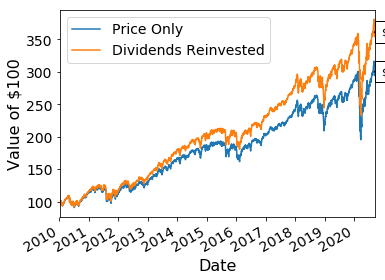

In [11]:
##Now let's plot the growth of $100 with and without dividend reinvesting.


%matplotlib inline
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

fig, ax = plt.subplots()
ax = normalized_df[['close','close_div_reinvest']].plot(ax=ax)

ab ={}
for key_now in ['close','close_div_reinvest']:
    xy = (df.iloc[-1].name, normalized_df.iloc[-1][key_now])

    # Annotate the 1st position with another text box ('Test')
    offsetbox = TextArea( "\$%6.2f" % (xy[1]), minimumdescent=False)

    ab[key_now] = AnnotationBbox(offsetbox, xy,
                        xybox=(1.02, xy[1]),
                        xycoords='data',
                        boxcoords=("axes fraction", "data"),
                        box_alignment=(0., 0.5),
                        arrowprops=dict(arrowstyle="->"))

    ax.add_artist(ab[key_now])

ax.set_xlabel('Date')
ax.set_ylabel('Value of \$100')

L=plt.legend()
L.get_texts()[0].set_text('Price Only')
L.get_texts()[1].set_text('Dividends Reinvested')

fig.tight_layout()
fig.subplots_adjust(right=0.875)
fig.savefig('../reports/figures/test.png')

In [12]:
#Let's save the data to file to make a plot in datawrapper.


In [13]:
#First, let's simply the date format, so datawrapper can read it.
normalized_df.index = normalized_df.index.strftime('%Y-%m-%d')

In [14]:
normalized_df[['close','close_plus_div','close_div_reinvest']].to_csv('../data/interim/VTI.csv')

In [15]:
#Let's save a version with only every 7th day's data.
normalized_df.iloc[::7, :][['close','close_plus_div','close_div_reinvest']].to_csv('../data/interim/VTI_7th.csv')

In [16]:
#Now let's simulate reinvesting dividends the most popular vanguard ETFs
#and calculate the the average annual return 
#over the past 5 years

In [122]:
#List of Vanguard ETF names and ticker symbols
van_list = [('Intermediate-Term Bond ETF', 'BIV'),
 ('Long-Term Bond ETF', 'BLV'),
 ('Short-Term Bond ETF', 'BSV'),
 ('Short-Term Inflation-Protected Securities ETF', 'VTIP'),
 ('Total Bond Market ETF', 'BND'),
 ('Tax-Exempt Bond ETF','VTEB'),
 ('S&P 500 ETF', 'VOO'),
 ('Total Stock Market ETF','VTI'),
 ('Extended Market ETF','VXF'),
 ('Total International Bond ETF','BNDX'),
 ('FTSE Developed Markets ETF','VEA'),
 ('Total International Stock ETF','VXUS'),
 ('FTSE Emerging Markets ETF','VWO'),
 ('Dividend Appreciation ETF', 'VIG'),
 ('High Dividend Yield ETF', 'VYM'),
 ('Growth ETF', 'VUG')]

In [19]:
#get data for all ETFs
tickers = []
for van in van_list:
    tickers.append(van[1])

In [20]:
df_van = pdr.get_data_tiingo(tickers, \
    api_key=my_key)

In [21]:
#Where do stock splits appear and do they affect our calculation? 
#(Answer: once but more than 5 years ago, so disregard)
df_van['splitFactor'][df_van['splitFactor'] != 1]

symbol  date                     
VOO     2013-10-24 00:00:00+00:00    0.5
Name: splitFactor, dtype: float64

In [22]:
#Move multiindexed df to dictionary for convience.
df_van_dict = {}
for tick in tickers:
    df_van_dict[tick] = df_van.loc[tick]

In [23]:
#Here's the simulation code above packaged into a function with some addition options available.

def norm_df(df, reinvest_on_open = True, normalize = True):
    # simply add the cumulative sum of the dividends to the closing price
    df['close_plus_div'] = df['close']+df['divCash'].cumsum()

    #initialize
    df['daily_cash_value_of_all_paid_div'] = 0.

    #iterate through each row with a dividend payment
    for row_id,series in df[df['divCash']>0].iterrows():
        row_id_number = np.flatnonzero(df.index == row_id)[0]
        #print(row_id)
        #calculate the return on each day relative to the closing price on the day this current dividend is paid
        if reinvest_on_open:
            a_value = df['open'].iloc[row_id_number+1]
        else:
            a_value = df['close'].iloc[row_id_number]
        percent_return_post_div = df['close']/a_value
        df['daily_cash_value_of_paid_div'] = series['divCash'] * percent_return_post_div

        #we don't get any cash return on div before it's paid,
        #so we set the the daily cash return to zero for days before dividend payment date
        df['daily_cash_value_of_paid_div'].loc[:row_id] = 0

        #now we add this dividend's daily value to all the other dividends
        df['daily_cash_value_of_all_paid_div'] = df['daily_cash_value_of_all_paid_div']+df['daily_cash_value_of_paid_div']


    #Now we add the daily value of the dividends to the closing price of the stock
    df['close_div_reinvest'] = df['close']+df['daily_cash_value_of_all_paid_div']

    if normalize:
        normalized_df=(df/df.iloc[0])*100
        return normalized_df
    else:
        return df

In [26]:
#Dictionary for only dates after Aug 31, 2015 and reinvesting on open the day after
df_van_norm_open_2015_dict = {}
for tick in tickers:
    df_van_norm_open_2015_dict[tick] = norm_df(df_van_dict[tick].loc[pd.Timestamp('Aug 31, 2015'):], reinvest_on_open = True)

/Users/stevans/anaconda3/envs/reinvesting_dividends/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/stevans/anaconda3/envs/reinvesting_dividends/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/stevans/anaconda3/envs/reinvesting_dividends/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a

In [27]:
#Function to get average annual return (AAR)
def get_aar(df, key_price, date_start, date_end, n_years):
    price_start = df.loc[pd.Timestamp(date_start)][key_price]
    price_end = df.loc[pd.Timestamp(date_end)][key_price]
    aar = (price_end / price_start) ** (1./float(n_years))
    return aar

In [28]:
#Calculate the AAR from the data when dividends are excluded (no), 
#included but not reinvested (in), and reinvested (re).
aar_no_div2015 = []
aar_in_div2015 = []
aar_re_div2015 = []
tick_list = []
for tick in df_van_norm_open_2015_dict.keys():
    tick_list.append(tick)
    aar_no_div2015.append(get_aar(df_van_norm_open_2015_dict[tick], 'close', 'August 31, 2015', \
        'August 31, 2020', 5))
    aar_in_div2015.append(get_aar(df_van_norm_open_2015_dict[tick], 'close_plus_div', 'August 31, 2015', \
        'August 31, 2020', 5))
    aar_re_div2015.append(get_aar(df_van_norm_open_2015_dict[tick], 'close_div_reinvest', 'August 31, 2015', \
        'August 31, 2020', 5))

In [40]:
#Repackage data for saving to file which we will then read into datawrapper to make the figure.
d2015 = {'tick':tick_list,'aar_no_div': aar_no_div2015,'aar_in_div': aar_in_div2015, 'aar_re_div': aar_re_div2015}
df_paired2015 = pd.DataFrame(data=d2015)
df_paired2015 = df_paired2015.set_index('tick')
df_paired2015 = df_paired2015 * 100. - 100. #Convert units from dollars to percent growth over 100%.
#Calculate the difference between three cominbations of the AAR components
df_paired2015['delta_in_no'] = df_paired2015['aar_in_div'] - df_paired2015['aar_no_div']
df_paired2015['delta_re_no'] = df_paired2015['aar_re_div'] - df_paired2015['aar_no_div']
df_paired2015['delta_re_in'] = df_paired2015['aar_re_div'] - df_paired2015['aar_in_div']

In [108]:
#Prepare for printing data to file
df_paired2015_for_printing = []
df_paired2015_for_printing = df_paired2015.copy()

In [109]:
#Let's add a Group column so we can make a grouped plot (instead of using asterisks to denote non-select ETFs)
df_paired2015_for_printing['Group']='Vanguard Select ETFs'
df_paired2015_for_printing['Group'].loc['VIG','VYM','VUG'] = 'Other Popular Vanguard ETFs'

In [110]:
#Rename the columns for labels that will be displayed in final figure
df_paired2015_for_printing['Capital Only'] = df_paired2015_for_printing['aar_no_div']
df_paired2015_for_printing['Dividends Only'] = df_paired2015_for_printing['delta_in_no']
df_paired2015_for_printing['Gains on Reinvested Dividends'] = df_paired2015_for_printing['delta_re_in']
df_paired2015_for_printing=df_paired2015_for_printing.drop(columns=['aar_no_div','aar_in_div','aar_re_div','delta_in_no','delta_re_no','delta_re_in'])

In [112]:
df_paired2015_for_printing.to_csv('../data/interim/van_paired2015.csv')

In [123]:
#Add long ETF name to column
df_paired2015_for_printing['Name'] = ''
for element in van_list:
    df_paired2015_for_printing['Name'].loc[element[1]] = element[0]

In [126]:
cols_new_order = ['Name','Group','Capital Gains Only','Dividend Gains Only','Gains from Reinvesting Div.']
df_paired2015_for_printing = df_paired2015_for_printing[cols_new_order]

In [128]:
df_paired2015_for_printing.to_csv('../data/interim/van_paired2015_named.csv')

In [131]:
#Appended ticker to long name
df_paired2015_for_printing = df_paired2015_for_printing.reset_index()
df_paired2015_for_printing['Full Name'] = df_paired2015_for_printing['Name'] + \
" ("+ df_paired2015_for_printing['tick'] + ")"

In [133]:
cols_new_order = ['Full Name','Group','Capital Gains Only','Dividend Gains Only','Gains from Reinvesting Div.']
df_paired2015_for_printing = df_paired2015_for_printing[cols_new_order]
df_paired2015_for_printing.set_index('Full Name')

,Group,Capital Gains Only,Dividend Gains Only,Gains from Reinvesting Div.
Full Name,,,,
Intermediate-Term Bond ETF (BIV),Vanguard Select ETFs,2.172032,2.485208,0.249666
Long-Term Bond ETF (BLV),Vanguard Select ETFs,4.778147,3.138224,0.573189
Short-Term Bond ETF (BSV),Vanguard Select ETFs,0.760179,1.716614,0.067884
Short-Term Inflation-Protected Securities ETF (VTIP),Vanguard Select ETFs,1.091388,1.253915,0.061262
Total Bond Market ETF (BND),Vanguard Select ETFs,1.667427,2.353312,0.178305
Tax-Exempt Bond ETF (VTEB),Vanguard Select ETFs,1.729993,1.866736,0.092832
S&P 500 ETF (VOO),Vanguard Select ETFs,12.128996,1.593639,0.577266
Total Stock Market ETF (VTI),Vanguard Select ETFs,11.643456,1.528477,0.557266
Extended Market ETF (VXF),Vanguard Select ETFs,9.173580,1.228976,0.368857


In [134]:
df_paired2015_for_printing.to_csv('../data/interim/van_paired2015_named2.csv')

In [46]:
#What is the mean difference betwee the AATR when dividends are included and dividends are reinvested?
df_paired2015.delta_re_in.mean()

0.29895133337722424

In [32]:
#Historical NAV from Vanguard's website
VTI_NAV_08312015 = 102.27
VTI_NAV_08312020 = 177.40
aatr_vti = (VTI_NAV_08312020 / VTI_NAV_08312015) ** (1./float(5))

In [33]:
print(aatr_vti)

1.1164546115281528


In [136]:
#Let's look at how the AAR components are correlated
import seaborn as sns

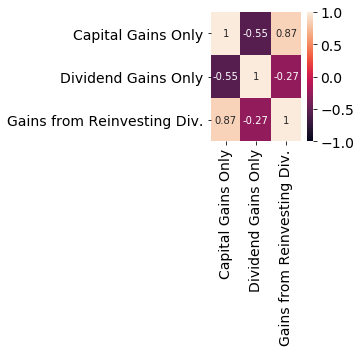

In [140]:
plt.figure(figsize=(5,5))
#sns.heatmap(df_paired2015_for_printing.corr())
#plot heat map
g=sns.heatmap(df_paired2015_for_printing.corr(),annot=True,vmin=-1, vmax=1) #,cmap="RdYlGn"
plt.tight_layout()